# ---
# import packages
# ---

In [44]:
# simple inline example of OI
# NOTE: there is no smoothing of hyper parameters

import os
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data


# ---
# read in raw data
# ---

In [45]:

# read in all the *_RAW.csv files in data/example
# - get files to read
raw_files = [get_data_path("example", i)
             for i in os.listdir(get_data_path("example")) if re.search("_RAW\.csv$", i)]

# read in, add source col
tmp = []
for rw in raw_files:
    source = re.sub("_RAW\.csv$", "", os.path.basename(rw))
    _ = pd.read_csv(rw)
    _['source'] = source
    tmp.append(_)
df = pd.concat(tmp)


# convert lon, lat, datetime to x, y, t - to be used as the coordinate space
# - x,y are in meters, t in days
df['x'], df['y'] = WGS84toEASE2_New(lon=df['lon'], lat=df['lat'], lat_0=90, lon_0=0)
df['t'] = df['datetime'].values.astype("datetime64[D]").astype(float)


# ---
# bin raw data
# ---

In [46]:
# bin by date, source to a 50x50km grid
# - returns a DataSet
bin_ds = DataPrep.bin_data_by(df=df.loc[(df['z'] > -0.35) & (df['z'] < 0.65)],
                              by_cols=['t', 'source'],
                              val_col='z',
                              x_col='x',
                              y_col='y',
                              grid_res=50_000,
                              x_range=[-4500000.0, 4500000.0],
                              y_range=[-4500000.0, 4500000.0])

# convert bin data to DataFrame
# - removing all the nans that would be added at grid locations away from data
bin_df = bin_ds.to_dataframe().dropna().reset_index()


'bin_data_by': 1.661 seconds


# --
# plot binned data
# --

'plot_pcolormesh': 0.029 seconds


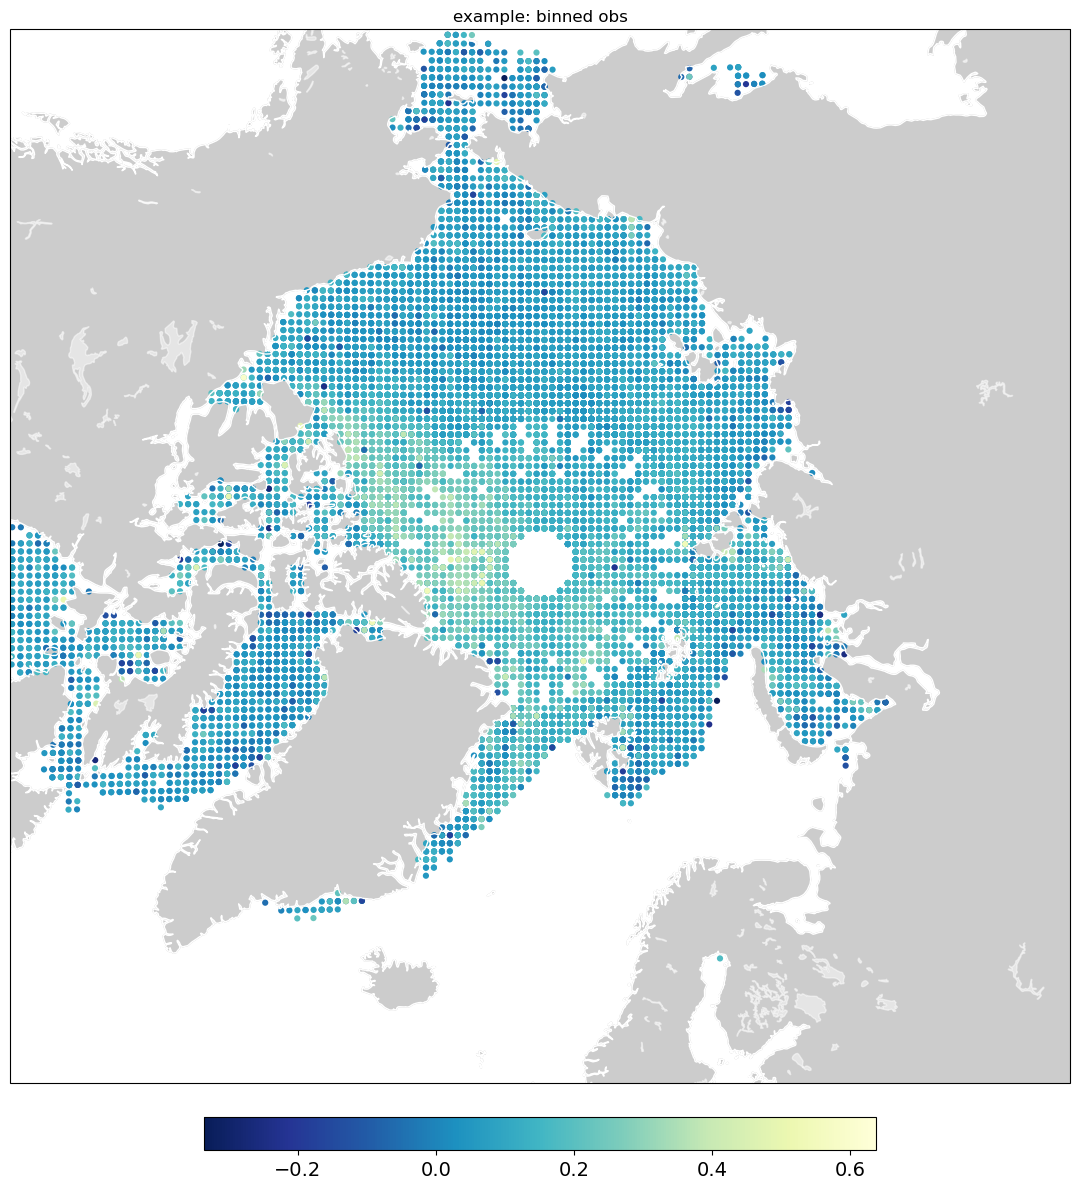

In [47]:
# this will plot all observations, some on top of each other
bin_df['lon'], bin_df['lat'] = EASE2toWGS84_New(bin_df['x'], bin_df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=bin_df['lon'],
                lat=bin_df['lat'],
                plot_data=bin_df['z'],
                title="example: binned obs",
                scatter=True,
                s=20,
                fig=fig,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()


# ---
# expert locations - on evenly spaced grid
# ---


In [48]:
# - spaced every 200km for some x,y range
xy_grid = grid_2d_flatten(x_range=[-500000.0, 500000.0],
                          y_range=[-500000.0, 500000.0],
                          step_size=200_000)

# store in dataframe
eloc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# add a time coordinate
eloc['t'] = np.floor(df['t'].mean())

# ---
# plot expert locations
# ---

'plot_pcolormesh': 0.008 seconds


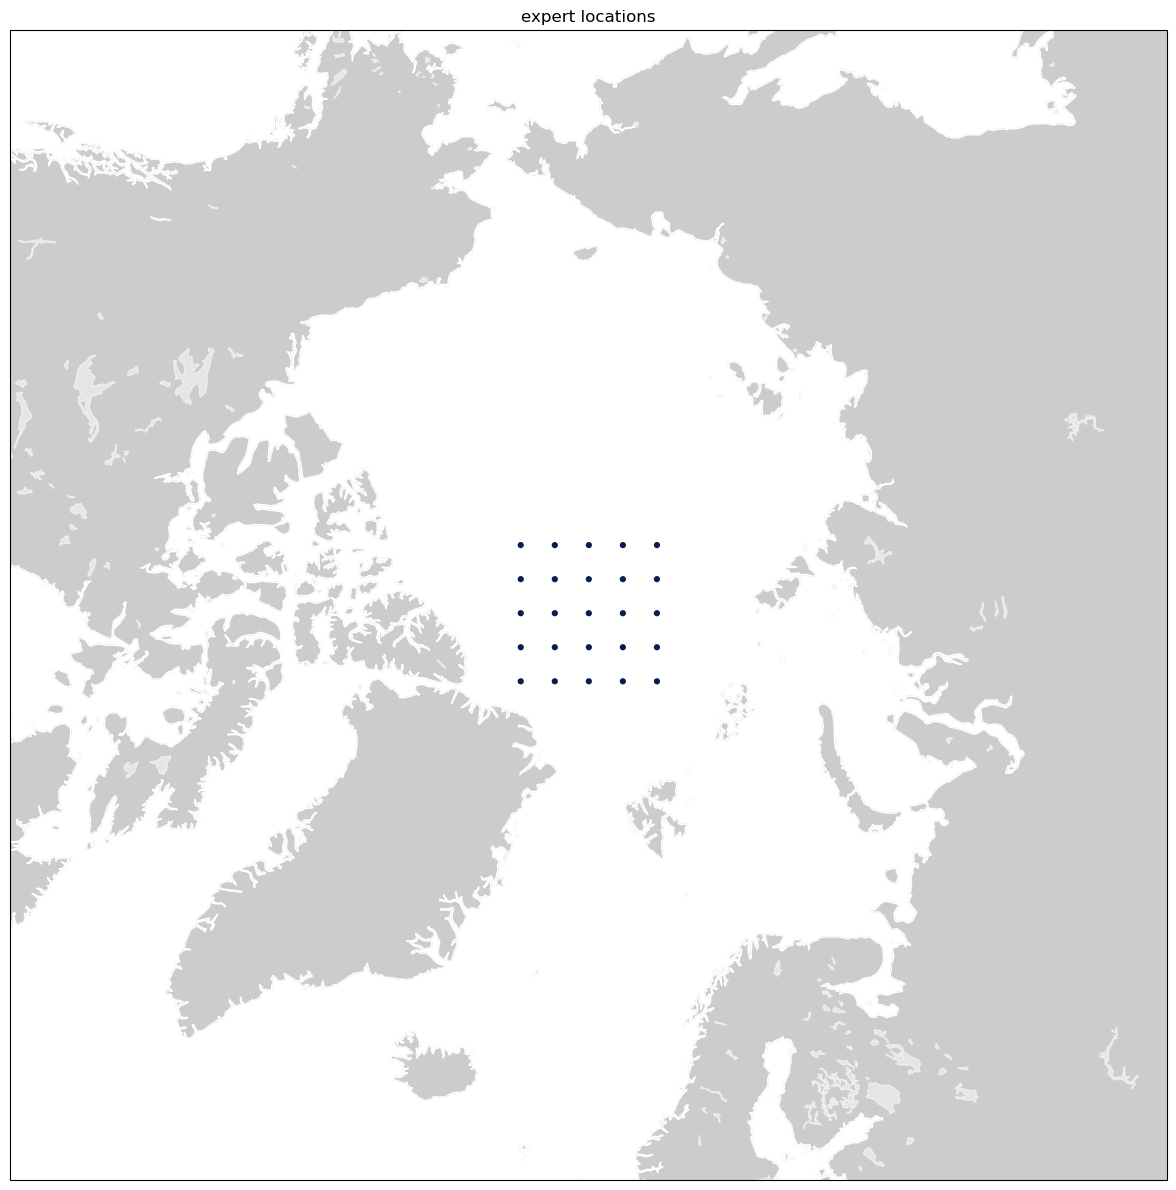

In [59]:

eloc['lon'], eloc['lat'] = EASE2toWGS84_New(eloc['x'], eloc['y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=eloc['lon'],
                lat=eloc['lat'],
                plot_data=eloc['t'],
                title="expert locations",
                scatter=True,
                s=20,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()


# ---
# prediction locations
# ---

In [58]:

# - spaced every 5km
xy_grid = grid_2d_flatten(x_range=[-500000.0, 500000.0],
                          y_range=[-500000.0, 500000.0],
                          step_size=5_000)

# store in dataframe
# NOTE: the missing 't' coordinate will be determine by the expert location
# - alternatively the prediction location can be specified
ploc = pd.DataFrame(xy_grid, columns=['x', 'y'])



# --
# plot prediction locations
# --

'plot_pcolormesh': 0.017 seconds


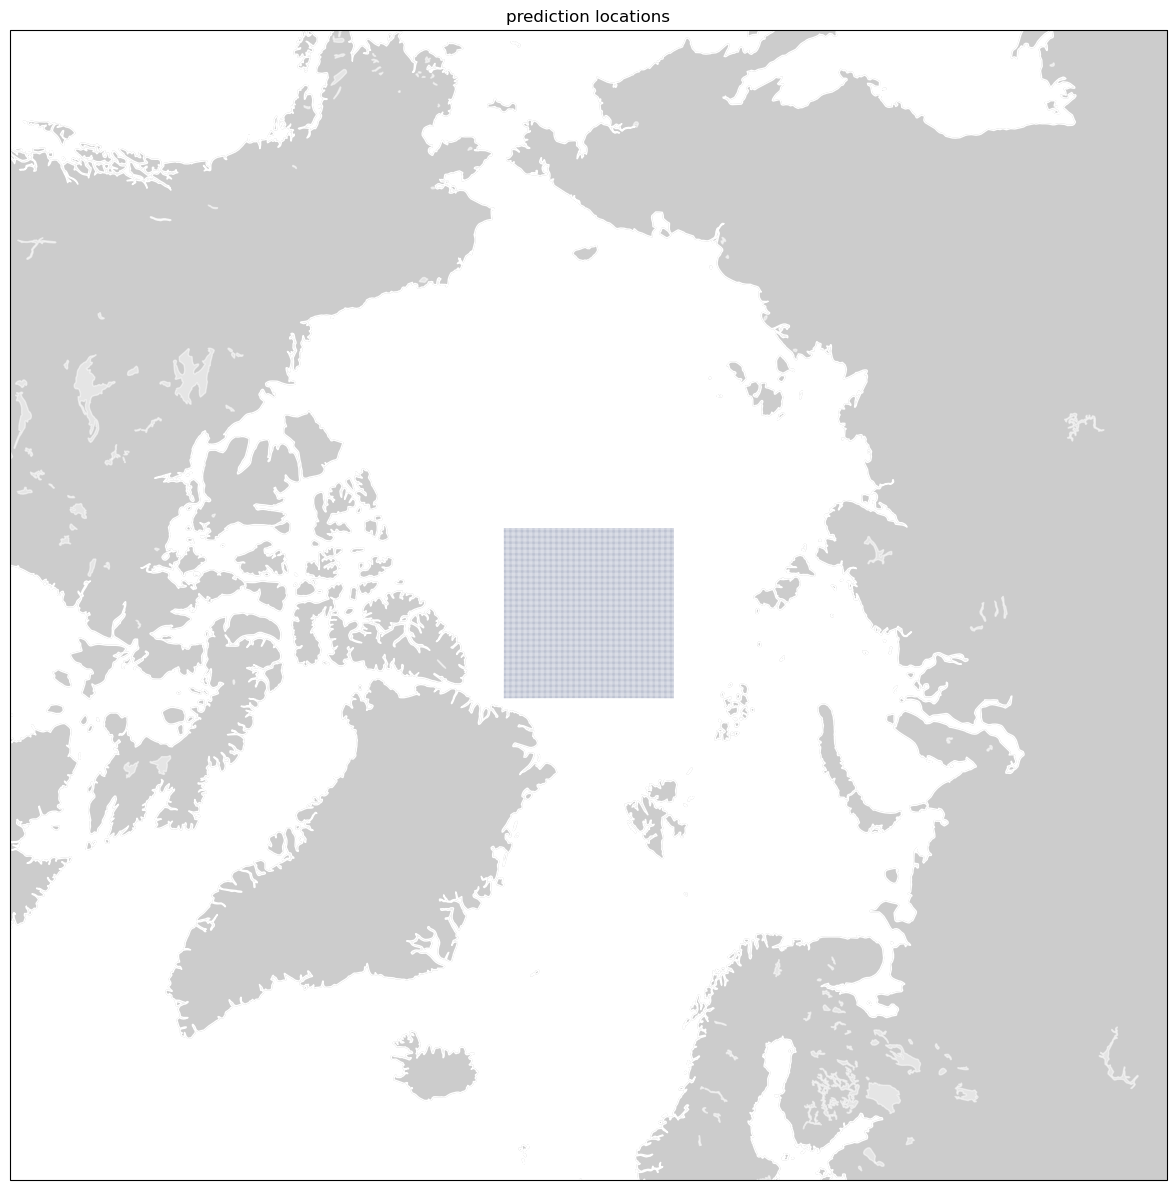

In [57]:
ploc['lon'], ploc['lat'] = EASE2toWGS84_New(ploc['x'], ploc['y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=ploc['lon'],
                lat=ploc['lat'],
                plot_data=np.full(len(ploc), 1.0), #np.arange(len(ploc)),
                title="prediction locations",
                scatter=True,
                s=0.1,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()


# ---
# configurations for Local Expert OI
# ---

In [52]:


# observation data
data = {
    "data_source": bin_df,
    "obs_col": "z",
    "coords_col": ["x", "y", "t"],
    # selection criteria used for each local expert
    "local_select": [
        {
            "col": "t",
            "comp": "<=",
            "val": 4
        },
        {
            "col": "t",
            "comp": ">=",
            "val": -4
        },
        {
            "col": [
                "x",
                "y"
            ],
            "comp": "<",
            "val": 300_000
        }
    ]
}

# local expert locations
local_expert = {
    "source": eloc
}

# model
model = {
    "oi_model": "GPflowGPRModel",
    "init_params": {
        # scale (divide) coordinates
        "coords_scale": [50000, 50000, 1]
    },
    "constraints": {
        # lengthscales - same order coord_col (see data)
        "lengthscales": {
            "low": [1e-08, 1e-08, 1e-08],
            "high": [600000, 600000, 9]
        }
    }
}

# prediction locations
# -
pred_loc = {
    "method": "from_dataframe",
    "df": ploc,
    "max_dist": 200_000
}


# ---
# Local Expert OI
# ---

In [53]:
locexp = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model,
                       pred_loc_config=pred_loc)



'data_select': 0.000 seconds
'load': 0.001 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 22522 >  100
storing as str
in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 40000 >  100
storing as str


# run optimal interpolation

In [54]:
# path to store results
store_path = get_parent_path("results", "inline_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=store_path,
           optimise=True)

removing: /home/buddy/workspace/pyOI/GPSat/results/inline_example.h5
---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details in the file'
will now close object

------------------------------
1 / 25
          x         y        t   lon        lat
0 -400000.0 -400000.0  18326.0 -45.0  84.933616
'data_select': 0.001 seconds
'load': 0.001 seconds
'_update_global_data': 0.001 seconds
'local_data_select': 0.005 seconds
number obs: 402
'_max_dist_bool': 0.000 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.058 seconds
'get_parameters': 0.003 seconds
'set_lengthscales_constraints': 0.004 seconds


2023-06-07 11:03:24.980575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:24.980731: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 0.817 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([5.18465096, 3.21942263, 8.99999653]) 
kernel_variance: 0.01524964869903467
likelihood_variance: 0.003326542615041826
'predict': 0.175 seconds
total run time : 1.26 seconds
------------------------------
2 / 25
          x         y        t        lon      lat
1 -200000.0 -400000.0  18326.0 -26.565051  85.9952
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 538
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.059 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:26.239372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:26.239588: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.475 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([3.77497994, 2.17843589, 8.99999927]) 
kernel_variance: 0.01336891264041309
likelihood_variance: 0.0020117133508804376
'predict': 0.325 seconds
total run time : 2.06 seconds
------------------------------
3 / 25
     x         y        t  lon        lat
2  0.0 -400000.0  18326.0  0.0  86.418156
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 519
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.057 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:28.298998: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:28.299170: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.327 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([4.40036077, 7.18173972, 8.99999752]) 
kernel_variance: 0.009122002736250325
likelihood_variance: 0.0018969489056914488
'predict': 0.302 seconds
total run time : 1.88 seconds
------------------------------
4 / 25
          x         y        t        lon      lat
3  200000.0 -400000.0  18326.0  26.565051  85.9952
'_update_global_data': 0.000 seconds
'local_data_select': 0.005 seconds
number obs: 525
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.059 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:30.185701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:30.185865: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


**********
optimization failed!
'optimise_parameters': 2.115 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([6.84411096, 6.23884813, 8.99922334]) 
kernel_variance: 0.014944105861717084
likelihood_variance: 0.0016663081225128781
'predict': 0.308 seconds
total run time : 2.68 seconds
------------------------------
5 / 25
          x         y        t   lon        lat
4  400000.0 -400000.0  18326.0  45.0  84.933616
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 409
'_max_dist_bool': 0.000 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.058 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:32.863243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:32.863410: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 0.836 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([6.71011634, 4.73244207, 8.99996978]) 
kernel_variance: 0.013182253090236627
likelihood_variance: 0.001630918440456292
'predict': 0.183 seconds
total run time : 1.27 seconds
------------------------------
6 / 25
          x         y        t        lon      lat
5 -400000.0 -200000.0  18326.0 -63.434949  85.9952
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 566
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.059 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:34.133238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:34.133414: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.856 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([6.87608234, 9.42143305, 3.38422214]) 
kernel_variance: 0.023411674372666252
likelihood_variance: 0.002445322458644346
'predict': 0.361 seconds
total run time : 2.48 seconds
------------------------------
7 / 25
          x         y        t   lon        lat
6 -200000.0 -200000.0  18326.0 -45.0  87.467477
'_update_global_data': 0.000 seconds
'local_data_select': 0.005 seconds
number obs: 548
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.059 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:36.609740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:36.609911: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.748 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([ 6.46143141, 11.9999999 ,  8.99998584]) 
kernel_variance: 0.02839477260531858
likelihood_variance: 0.0018269914567138207
'predict': 0.418 seconds
total run time : 2.43 seconds
------------------------------
8 / 25
     x         y        t  lon        lat
7  0.0 -200000.0  18326.0  0.0  88.209314
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 501
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.062 seconds
'set_lengthscales_constraints': 0.004 seconds


2023-06-07 11:03:39.048301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:39.048484: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.278 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([6.08673993, 5.81866098, 8.99999752]) 
kernel_variance: 0.00991105097014833
likelihood_variance: 0.0015218498277788726
'predict': 0.358 seconds
total run time : 1.92 seconds
------------------------------
9 / 25
          x         y        t   lon        lat
8  200000.0 -200000.0  18326.0  45.0  87.467477
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 525
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.065 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:40.966792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:40.966969: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 0.998 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([8.09488553, 4.33119749, 8.17985802]) 
kernel_variance: 0.013010925650631392
likelihood_variance: 0.0012718495633289684
'predict': 0.370 seconds
total run time : 1.64 seconds
------------------------------
10 / 25
          x         y        t        lon      lat
9  400000.0 -200000.0  18326.0  63.434949  85.9952
'_update_global_data': 0.000 seconds
'local_data_select': 0.005 seconds
number obs: 569
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.060 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:42.607041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:42.607217: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.841 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([11.91847859,  6.48978464,  8.71646597]) 
kernel_variance: 0.013950801705089545
likelihood_variance: 0.00167059613093526
'predict': 0.360 seconds
SAVING RESULTS
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 2.63 seconds
------------------------------
11 / 25
           x    y        t   lon        lat
10 -400000.0  0.0  18326.0 -90.0  86.418156
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 591
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.073 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:45.250941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:45.251128: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


**********
optimization failed!
'optimise_parameters': 2.743 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([ 7.24270769, 11.99997651,  3.8069878 ]) 
kernel_variance: 0.0195554995659887
likelihood_variance: 0.002365762564179275
'predict': 0.368 seconds
total run time : 3.39 seconds
------------------------------
12 / 25
           x    y        t   lon        lat
11 -200000.0  0.0  18326.0 -90.0  88.209314
'_update_global_data': 0.000 seconds
'local_data_select': 0.005 seconds
number obs: 516
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.057 seconds
'set_lengthscales_constraints': 0.004 seconds


2023-06-07 11:03:48.625320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:48.625493: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.445 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([12.        , 11.9995829 ,  4.77314498]) 
kernel_variance: 0.027796324179487592
likelihood_variance: 0.0019514732738718646
'predict': 0.374 seconds
total run time : 2.07 seconds
------------------------------
13 / 25
      x    y        t  lon   lat
12  0.0  0.0  18326.0  0.0  90.0
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 522
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.060 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:50.700466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:50.700624: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.862 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([10.80292233,  9.27875587,  8.99999547]) 
kernel_variance: 0.012823534891082825
likelihood_variance: 0.0009243460175321353
'predict': 0.379 seconds
total run time : 2.50 seconds
------------------------------
14 / 25
           x    y        t   lon        lat
13  200000.0  0.0  18326.0  90.0  88.209314
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 501
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.058 seconds
'set_lengthscales_constraints': 0.004 seconds


2023-06-07 11:03:53.202981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:53.203157: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.179 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([10.88231347,  5.80287047,  8.99990292]) 
kernel_variance: 0.014741971030856938
likelihood_variance: 0.0012912252129256645
'predict': 0.369 seconds
total run time : 1.81 seconds
------------------------------
15 / 25
           x    y        t   lon        lat
14  400000.0  0.0  18326.0  90.0  86.418156
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 564
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.061 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:55.012924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:55.013102: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.421 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([9.75705831, 6.26351574, 8.99942231]) 
kernel_variance: 0.008281664807741517
likelihood_variance: 0.0013507439216457607
'predict': 0.358 seconds
total run time : 2.04 seconds
------------------------------
16 / 25
           x         y        t         lon      lat
15 -400000.0  200000.0  18326.0 -116.565051  85.9952
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 556
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.060 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:57.057517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:57.057686: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.399 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([ 7.10922233, 11.99998086,  3.40261094]) 
kernel_variance: 0.02040262098217625
likelihood_variance: 0.001968821161274668
'predict': 0.342 seconds
total run time : 2.00 seconds
------------------------------
17 / 25
           x         y        t    lon        lat
16 -200000.0  200000.0  18326.0 -135.0  87.467477
'_update_global_data': 0.000 seconds
'local_data_select': 0.005 seconds
number obs: 556
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.058 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:03:59.057948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:03:59.058124: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


**********
optimization failed!
'optimise_parameters': 2.633 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([11.99979838, 11.99998726,  3.79100529]) 
kernel_variance: 0.021743217995136354
likelihood_variance: 0.0017348427402755307
'predict': 0.414 seconds
total run time : 3.30 seconds
------------------------------
18 / 25
      x         y        t    lon        lat
17  0.0  200000.0  18326.0  180.0  88.209314
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 513
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.064 seconds
'set_lengthscales_constraints': 0.004 seconds


2023-06-07 11:04:02.369314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:04:02.369489: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.332 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([6.7817723 , 7.24644385, 8.99975688]) 
kernel_variance: 0.00890584784017103
likelihood_variance: 0.001167462088209306
'predict': 0.365 seconds
total run time : 1.97 seconds
------------------------------
19 / 25
           x         y        t    lon        lat
18  200000.0  200000.0  18326.0  135.0  87.467477
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 532
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.061 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:04:04.337454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:04:04.337614: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.224 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([ 7.4671965 , 11.99965854,  8.99989096]) 
kernel_variance: 0.007193455645966836
likelihood_variance: 0.001410708364242678
'predict': 0.392 seconds
total run time : 1.88 seconds
------------------------------
20 / 25
           x         y        t         lon      lat
19  400000.0  200000.0  18326.0  116.565051  85.9952
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 540
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.061 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:04:06.219265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:04:06.219435: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.547 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([11.99986057,  7.62173691,  7.89761945]) 
kernel_variance: 0.010422147997118129
likelihood_variance: 0.0014468907518710627
'predict': 0.331 seconds
SAVING RESULTS
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 2.31 seconds
------------------------------
21 / 25
           x         y        t    lon        lat
20 -400000.0  400000.0  18326.0 -135.0  84.933616
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 450
'_max_dist_bool': 0.000 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.067 seconds
'set_lengthscales_constraints': 0.006 seconds


2023-06-07 11:04:08.529856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:04:08.530019: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


**********
optimization failed!
'optimise_parameters': 1.501 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([11.99999239, 12.        ,  2.99902681]) 
kernel_variance: 0.018776561637263326
likelihood_variance: 0.001740819973925233
'predict': 0.202 seconds
total run time : 1.97 seconds
------------------------------
22 / 25
           x         y        t         lon      lat
21 -200000.0  400000.0  18326.0 -153.434949  85.9952
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 543
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.057 seconds
'set_lengthscales_constraints': 0.004 seconds


2023-06-07 11:04:10.498294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:04:10.498466: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.524 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([4.97036936, 8.5390908 , 8.99999945]) 
kernel_variance: 0.010471463328775008
likelihood_variance: 0.00145085432037354
'predict': 0.329 seconds
total run time : 2.11 seconds
------------------------------
23 / 25
      x         y        t    lon        lat
22  0.0  400000.0  18326.0  180.0  86.418156
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 552
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.057 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:04:12.606573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:04:12.606740: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.459 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([ 5.59741607, 11.99999006,  8.99999989]) 
kernel_variance: 0.008970373589054309
likelihood_variance: 0.0016417999651993712
'predict': 0.354 seconds
total run time : 2.07 seconds
------------------------------
24 / 25
           x         y        t         lon      lat
23  200000.0  400000.0  18326.0  153.434949  85.9952
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 536
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.063 seconds
'set_lengthscales_constraints': 0.005 seconds


2023-06-07 11:04:14.684083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:04:14.684253: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'optimise_parameters': 1.717 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([11.99744328, 11.99988525,  8.99980548]) 
kernel_variance: 0.005548741145732404
likelihood_variance: 0.0014619263704975503
'predict': 0.341 seconds
total run time : 2.32 seconds
------------------------------
25 / 25
           x         y        t    lon        lat
24  400000.0  400000.0  18326.0  135.0  84.933616
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 431
'_max_dist_bool': 0.000 seconds
'_from_dataframe': 0.001 seconds
setting lengthscales to: [1. 1. 1.]
'__init__': 0.075 seconds
'set_lengthscales_constraints': 0.006 seconds


2023-06-07 11:04:17.012932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 11:04:17.013110: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


**********
optimization failed!
'optimise_parameters': 1.764 seconds
'get_parameters': 0.003 seconds
parameters:
lengthscales: array([11.99999348,  7.11591969,  8.05462876]) 
kernel_variance: 0.005866103616437794
likelihood_variance: 0.001212869467110894
'predict': 0.211 seconds
total run time : 2.25 seconds
storing any remaining tables
SAVING RESULTS
run_details
preds
lengthscales
kernel_variance
likelihood_variance
'run': 54.884 seconds


# ---
# results (predictions and parameters) are store in hdf5
# ---

In [55]:

# extract, store in dict
dfs, _ = get_results_from_h5file(store_path)

print(f"tables in results file: {list(dfs.keys())}")


reading in results
getting all tables
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
tables in results file: ['expert_locs', 'kernel_variance', 'lengthscales', 'likelihood_variance', 'oi_config', 'preds', 'run_details']


# ---
# plot the predictions
# ---

'data_select': 0.001 seconds
'load': 0.002 seconds
'plot_pcolormesh': 0.043 seconds


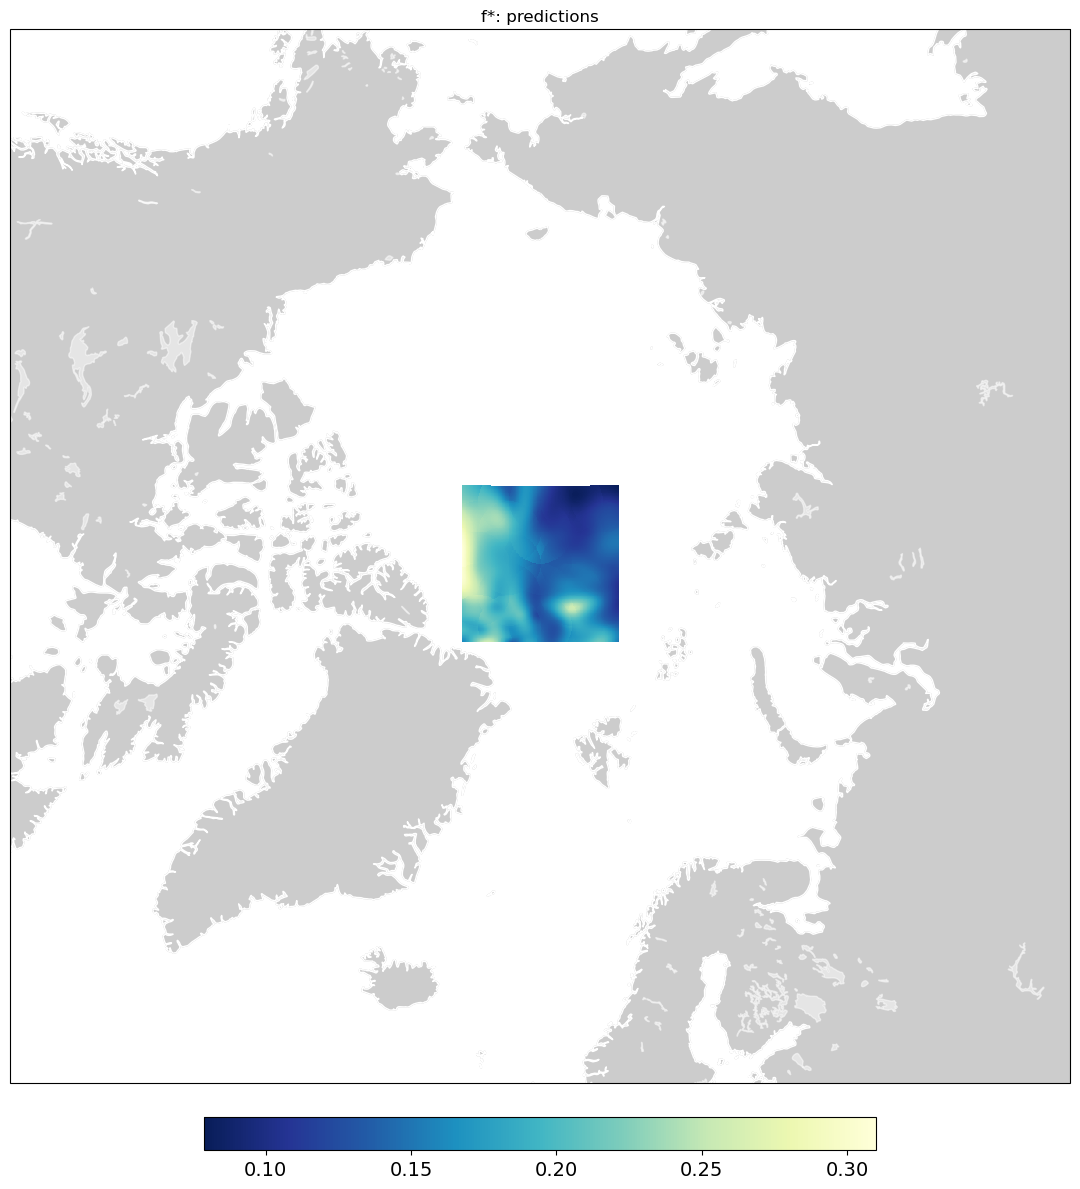

In [56]:
plt_data = dfs["preds"]

# multiple local experts may make predictions at the same prediction location (pred_loc).
# - for each prediction at a given location, take we weighted combination
# - weights being a function of the distance to each local expert that made a prediction at a given location.
weighted_values_kwargs = {
        "ref_col": ["pred_loc_x", "pred_loc_y", "pred_loc_t"],
        "dist_to_col": ["x", "y", "t"],
        "val_cols": ["f*", "f*_var"],
        "weight_function": "gaussian",
        "lengthscale": 200_000
    }
plt_data = get_weighted_values(df=plt_data, **weighted_values_kwargs)

# add convert x,y to lon,lat
plt_data['lon'], plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'], plt_data['pred_loc_y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))
plot_pcolormesh_from_results_data(ax=ax,
                                  dfs={"preds": plt_data},
                                  table='preds',
                                  val_col="f*",
                                  scatter=False,
                                  x_col='pred_loc_x',
                                  y_col='pred_loc_y',
                                  fig=fig,
                                  plot_kwargs={"title": "f*: predictions"})
plt.tight_layout()
plt.show()





